# Introduction
In this project we are going to analyze 'Brain tumor dataset', a T1 weighted MRI dataset from figshare,
<br>
apply preprocessing functions and create image classification model based on Convolutional neural network that predicts brain tumor type.
#### This project inludes:
- Image data analysis
- Preprocessing data
- Image classification model
- Final conclusion and thoughts
<br>

Highly reccomended to read the **data-description.txt** file to understand data organization.

# I Data preparation
#### Step 1 - Image extraction
The Dataset is in .mat format, so we extract the image values to regular image files.
<br>
For this task we're going to use h2py and PIL libraries and iterate through mat dataset.
<br><br>
*We don't really need to do that, but I want to show the process as working with regular images.
<br>
Technically we supposed to to assign labels to integer values because later on we'll use loss='sparse_categorical_crossentropy' which is prepared for said value type.

In [39]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

# apply stable seed to avoid inconsistent results every time we test new setup
tf.keras.utils.set_random_seed(0)
tf.random.set_seed(0)
np.random.seed(0)

# define paths for dataset
mat_path = 'D:\\data-science\\brain-tumor-data\\mat'
data_path = 'D:\\data-science\\brain-tumor-data\\images'
data_path_after = 'D:\\data-science\\brain-tumor-data\\processed_images'
matrices = os.listdir(mat_path)

# DON'T MIND THIS, it's dark theme for matplotlib
WHITE_MID = '#b5b5b5'
GREY_DARK = '#141414'

plt.rcParams['figure.facecolor'] = GREY_DARK
plt.rcParams['text.color'] = WHITE_MID
plt.rcParams['axes.facecolor'] = GREY_DARK
plt.rcParams['axes.edgecolor'] = WHITE_MID
plt.rcParams['axes.labelcolor'] = WHITE_MID
plt.rcParams['axes.titlecolor'] = WHITE_MID

plt.rcParams['grid.color'] = WHITE_MID
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['axes.grid'] = True

plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.color'] = WHITE_MID
plt.rcParams['ytick.color'] = WHITE_MID
plt.rcParams['legend.edgecolor'] = WHITE_MID
plt.rcParams['legend.labelcolor'] = WHITE_MID

In [40]:
from skimage import exposure
import h5py

label_names = {1: 'meningioma',
               2: 'glioma',
               3: 'pituitary'}

# this iteration generates .png files in data_path directory
for i, mat in enumerate(matrices):
    break
    
    # reads the .mat files from mat data path
    with h5py.File(f"{mat_path}\\{mat}", 'r') as file:
        image = file['cjdata']['image']
        label = int(file['cjdata']['label'][0])

        # normalize values by maximum where [min, max] = [0, 1]
        image = np.array(image) / np.max(image)
        
        # taking off 'near black' values to reduce background noise
        image[image <= 0.05] = 0

        # increase exposure
        # image = exposure.equalize_hist(image)
        
        # apply contrast stretching
        image = exposure.rescale_intensity(image)

        image *= 255
        image = np.array(image).astype(np.uint8)
        img_values = Image.fromarray(image)

        file_name = label_names[label] + f"_{i}.png"
        
        #saves the results to new data path
        img_values.save(data_path_after + '\\' + label_names[label] + '\\' + file_name)
    # print(f"{int((i + 1) / 3064)} %")

This plot visualise each step of transforming image data for 3 random data samples.
<br><br>
*While _background cleaning_ is actually first step,
<br>
I put it at the end to make difference more visually noticeable.

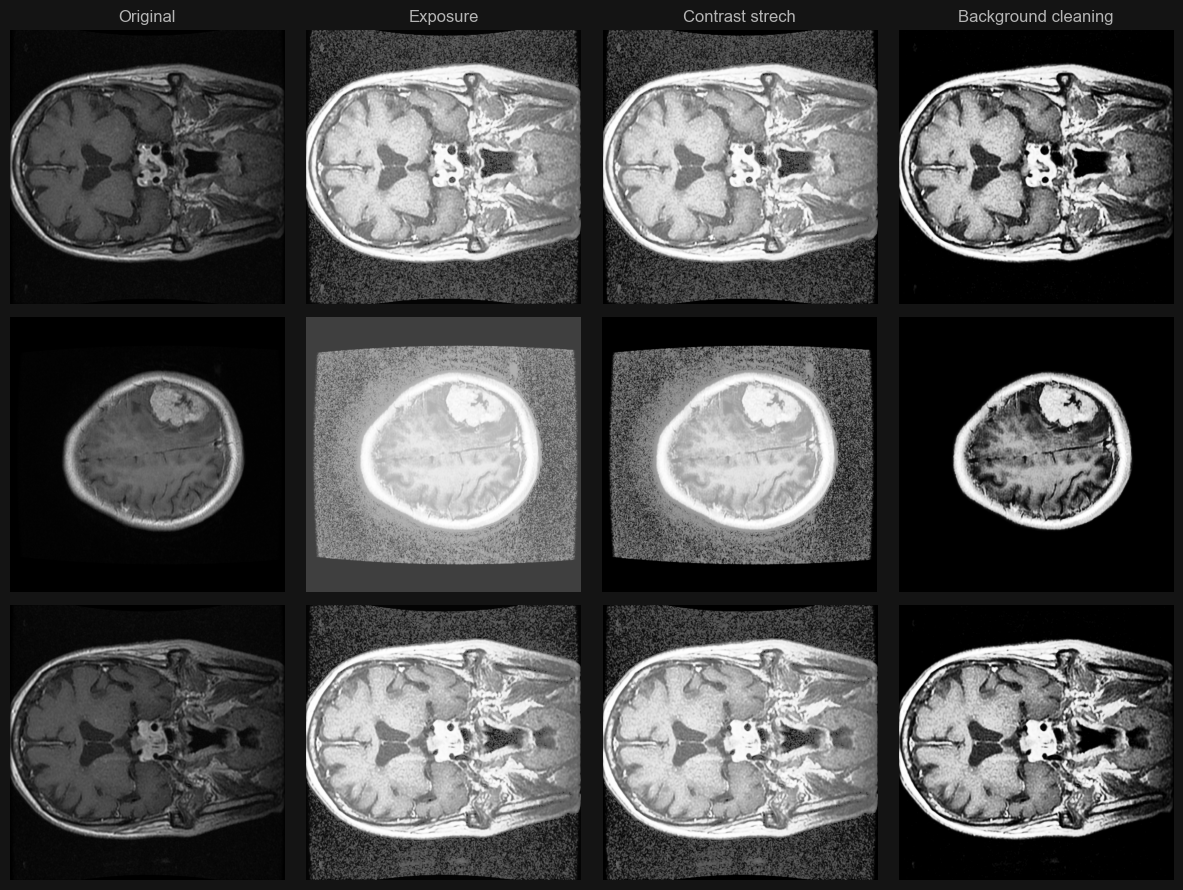

In [41]:
from PIL import Image

test_path = 'D:\\data-science\\brain-tumor-data\\test'
test_files = os.listdir(test_path)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 9))

for i, file in enumerate(test_files):
    img = Image.open(test_path + '\\' + file)
    y, x = [int(x[0]) for x in file.split('_')[1:]]
    
    axes[y, x].imshow(img, cmap='grey', vmin=0, vmax=255)
    axes[y, x].set_axis_off()
    
axes[0, 0].set_title('Original')
axes[0, 1].set_title('Exposure')
axes[0, 2].set_title('Contrast strech')
axes[0, 3].set_title('Background cleaning')
plt.tight_layout()

In [42]:
data = tf.keras.utils.image_dataset_from_directory(data_path, batch_size=8, color_mode='grayscale', image_size=(256, 256))
labels = data.class_names
labels

Found 3064 files belonging to 3 classes.


['glioma', 'meningioma', 'pituitary']

Data iterator allows us to move through data and preview it more swiftly.

In [43]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

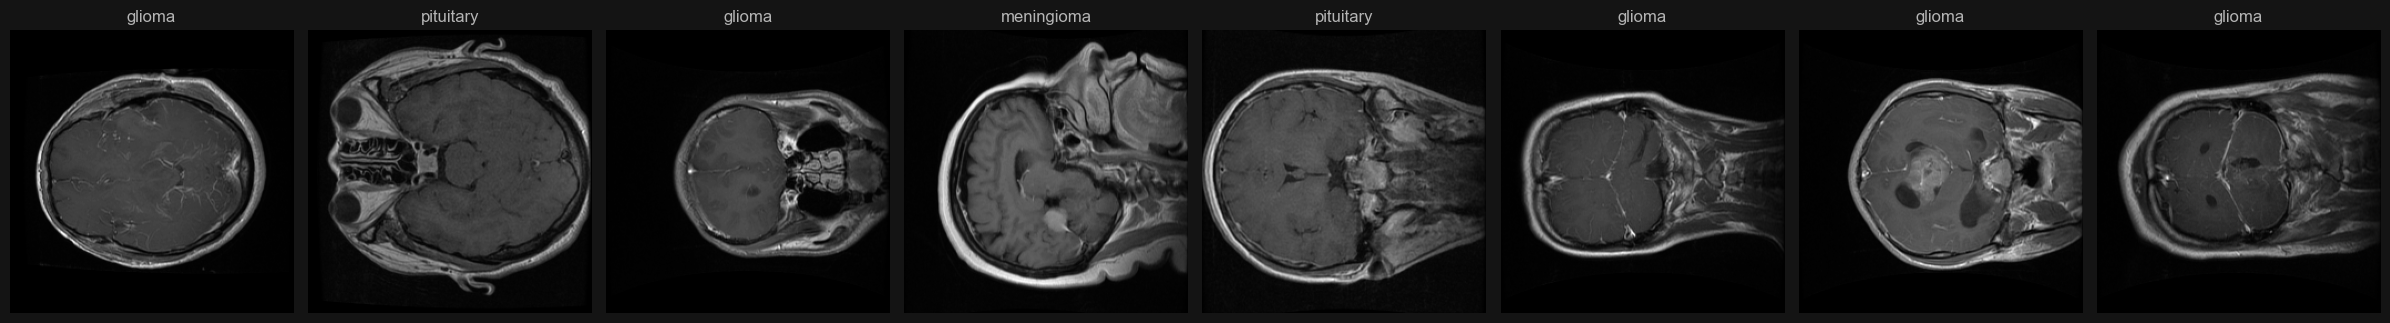

In [44]:
import matplotlib.pyplot as plt
import seaborn as sb

fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(24, 6))
for i, img in enumerate(batch[0][:8]):
    class_name = labels[batch[1][i]]
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(class_name)
    axes[i].set_axis_off()

plt.tight_layout()
plt.show()

In [45]:
batch[0].shape

(8, 256, 256, 1)

Our dataset contains 512px x 512px images and each pixel has 3 channels so basically each image contains **786 432** values,
<br>
with *color_mode = 'grayscale'* we reduce it to **262 144**. Also keras resized our files to size of 256px x 256px so we end up with **65 536** values per image.

    glioma: 1426
meningioma: 708
 pituitary: 930


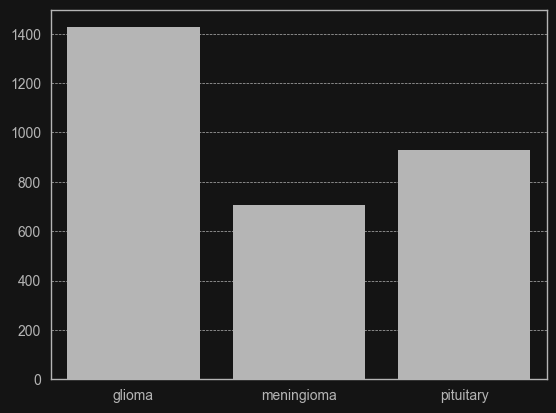

In [46]:
files_per_label = lambda folder: os.listdir(data_path + '\\' + folder)

# generate dictionary with lengths for each label
labels_len = {label: len(files_per_label(label)) for i, label in enumerate(labels)}

sb.barplot(data=labels_len, x=labels_len.keys(), y=labels_len.values(), color=WHITE_MID, linewidth=0)

for i, label in enumerate(labels):
    print(f"{label:>10}: {len(os.listdir(f"{data_path}\\{label}"))}")
    
plt.show()

I tested downsampling by removing random files from glioma and pituitary folders. However it didn't help at all, it even dropped accuracy by almost 10%,
<br>
apparently *glioma* class needs more support, because when we remove the data, accuracy on this class drop significantly. 
<br>
**Class weights** on the other hand increased the final results by round 5% (+10% for meningioma).

#### Step 2 - Feature scaling
Usually when we work with Images, the max value is 255 so we're going to transform our values from [min, max] = [0, 255] to [0, 1].

In [47]:
print(batch[0].min(), batch[0].max(), sep='\n')

0.0
251.5


In [48]:
data = data.map(lambda x, y: (x/255, y))

iterator = data.as_numpy_iterator()
batch = iterator.next()

min_value = iterator.next()[0].min()
max_value = iterator.next()[0].max()

print(min_value, max_value, sep='\n')

0.0
0.9941176


#### Checking black/white balance in images.
Every point on the plot is a single image, we can note that most of images hang around ratio of 0.27.

          Mean: 0.17968210577964783
 Harmonic mean: 0.1733316332101822


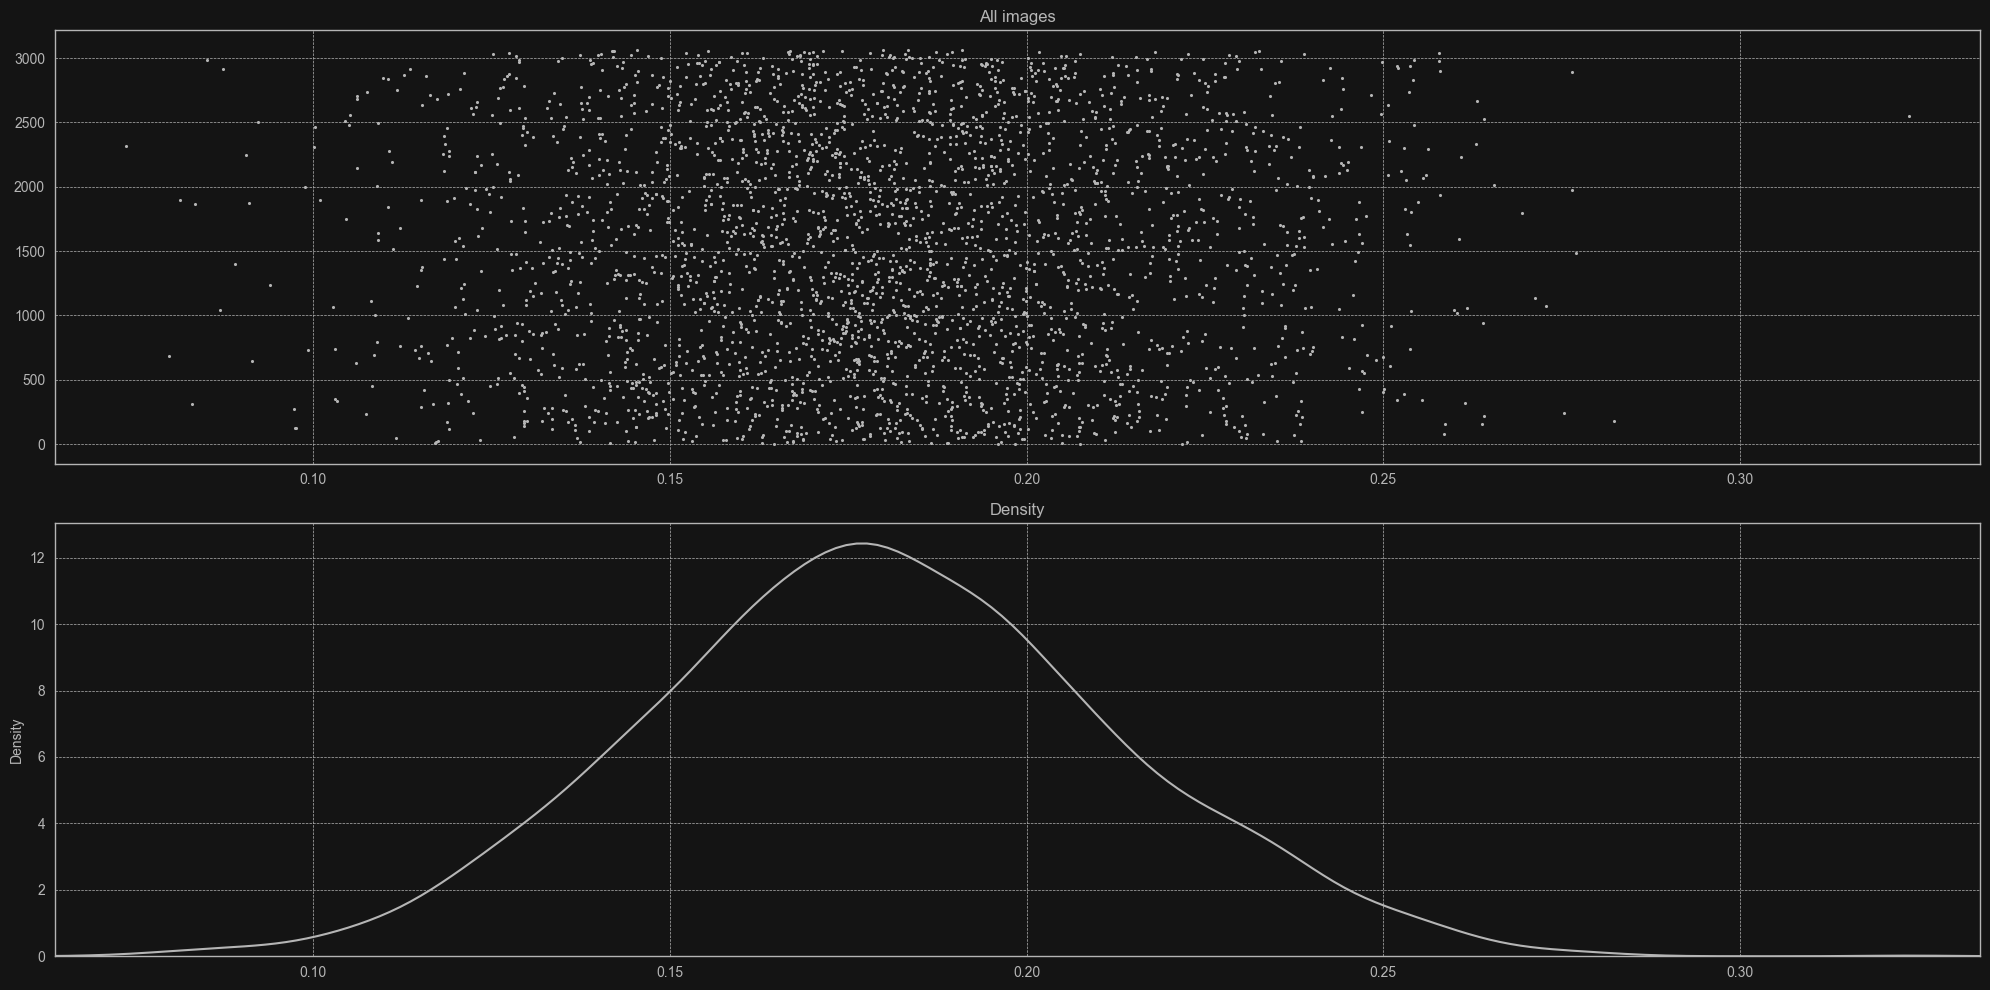

In [49]:
from scipy.stats.mstats import hmean

all_images = []
for images, label in data:
    all_images.append(images.numpy())

all_images = np.concatenate(all_images, axis=0)

# skipping value 0 because it's background and it will lower our mean
all_means = [x[x != 0].mean() for x in all_images]

print(f'{'Mean':>14}: {np.mean(all_means)}\n'
      f'{'Harmonic mean':>14}: {hmean(all_means)}')

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
sb.scatterplot(y=[x for x in range(len(all_means))], x=all_means, color=WHITE_MID, s=20, ax=axes[0], marker='.', linewidth=0)
sb.kdeplot(x=all_means, ax=axes[1], color=WHITE_MID)

padding = (min(all_means) - 0.01, max(all_means) + 0.01)
axes[0].set_xlim(padding)
axes[0].set_title('All images')
axes[1].set_xlim(padding)
axes[1].set_title('Density')
plt.tight_layout()

# II Building CNN Model
In short our model base on convolutional layers, where each layer contain filter that convolve with input matrix (image) resulting filtered output.
<br>
- As input shape we apply values that corresponds to:
    - width = 256
    - height = 256
    - channel = 1 (grayscale).
<br>
- __*ReLU*__ activation function cleans our output from all unecesary negative values, replacing them with zeros that came from filter multiplication.
<br>
- Since our dataset contain 3 classes I applied __*softmax*__ activation to the last step.

In [50]:
# data split
train_batch_size = round(len(data) * 0.7)
val_batch_size = round(len(data) * 0.2)
test_batch_size = round(len(data) * 0.1)

len(data) == train_batch_size + val_batch_size + test_batch_size

True

In [51]:
train = data.take(train_batch_size)
val = data.skip(train_batch_size).take(val_batch_size)
test = data.skip(train_batch_size + val_batch_size).take(test_batch_size)

print(
    f"train: {len(train)} batches, {len(train)*8} files\nval: {len(val)} batches, {len(val)*8} files\ntest: {len(test)} batches, {len(test)*8} files"
)

train: 268 batches, 2144 files
val: 77 batches, 616 files
test: 38 batches, 304 files


Formula for class weight:
<br><br>
$w_c = \frac{N}{N_c * C}$
<br><br>
where:
<br>
$ w_c $ = class weight <br>
$ N $ = number of samples in dataset <br>
$ N_c $ = number of samples in class <br>
$ C $ = number of unique classes in dataset

In [52]:
class_weights = dict()

for i, count in enumerate(labels_len.values()):
    class_weights[i] = (len(data)*8) / (len(labels) * count)

print(class_weights)

{0: 0.7162225338943432, 1: 1.4425612052730696, 2: 1.0982078853046595}


In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input, ReLU
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import Adam, SGD

In [63]:
def create_model(num_filters=16, kernel_size=3, learning_rate=0, regulate=0, slope=0):
    
    model = Sequential()
    
    model.add(Input(shape=(256, 256, 1)))
    
    model.add(Conv2D(num_filters, (kernel_size, kernel_size), 1, activation='relu'))
    model.add(MaxPooling2D())
    
    model.add(Conv2D(num_filters, (kernel_size, kernel_size), 1, activation='relu'))
    model.add(MaxPooling2D())
    
    model.add(Conv2D(num_filters, (kernel_size, kernel_size), 1, activation='relu'))
    model.add(MaxPooling2D())
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.7))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    
    return model

In [64]:
model = create_model(learning_rate=0.0002, slope=0)
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 254, 254, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 125, 125, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 60, 60, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,692,227 (14.08 MB)

 Trainable params: 3,692,227 (14.08 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
n_epochs = 20
hist = model.fit(train, epochs=n_epochs, validation_data=val, class_weight=class_weights)

Epoch 1/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - loss: 0.9195 - sparse_categorical_accuracy: 0.5292 - val_loss: 0.5691 - val_sparse_categorical_accuracy: 0.7906
Epoch 2/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - loss: 0.6502 - sparse_categorical_accuracy: 0.6653 - val_loss: 0.4794 - val_sparse_categorical_accuracy: 0.8149
Epoch 3/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - loss: 0.5283 - sparse_categorical_accuracy: 0.7633 - val_loss: 0.3861 - val_sparse_categorical_accuracy: 0.8604
Epoch 4/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 17s 64ms/step - loss: 0.4442 - sparse_categorical_accuracy: 0.8019 - val_loss: 0.3776 - val_sparse_categorical_accuracy: 0.8653
Epoch 5/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 17s 64ms/step - loss: 0.3882 - sparse_categorical_accuracy: 0.8394 - val_loss: 0.3142 - val_sparse_categorical_accuracy: 0.8734
Epoch 6/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - loss: 0.3455 - sparse_categorical_accuracy: 0.8554 - val_loss: 0.3302 - val_sparse_categorical_accuracy:

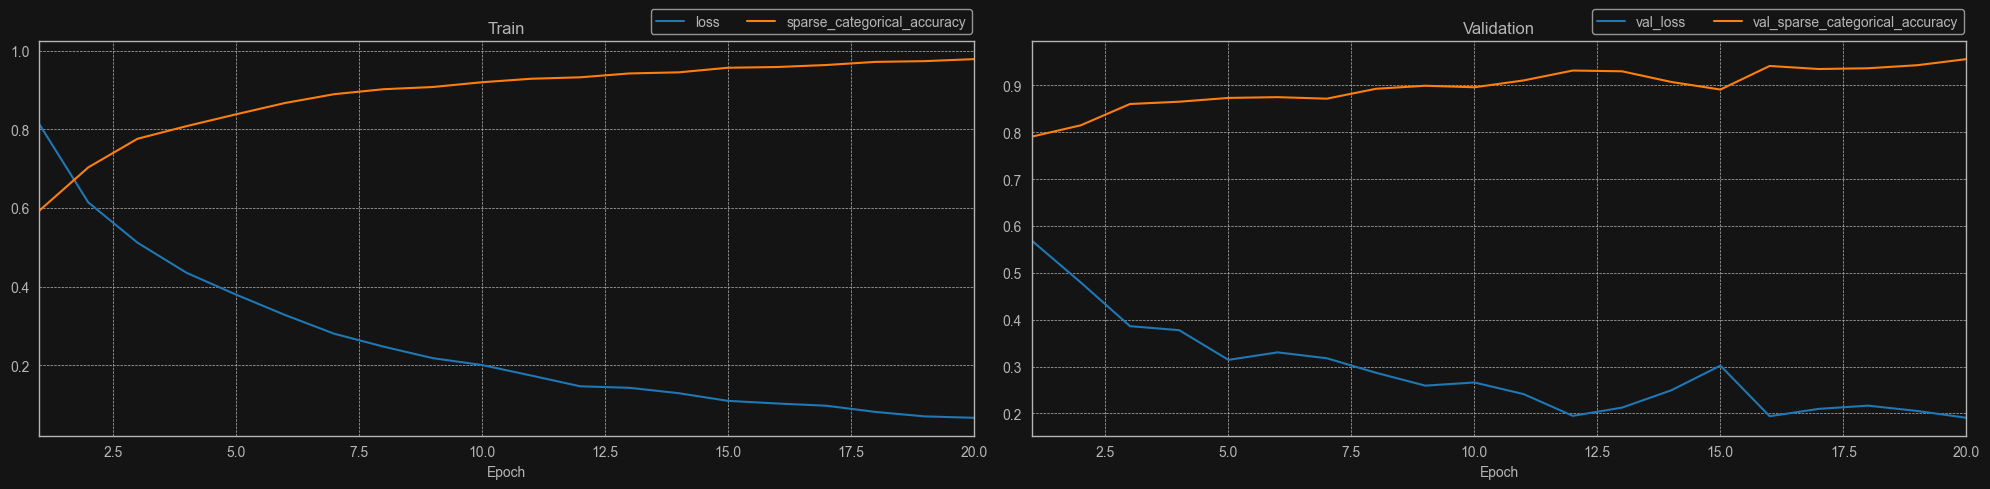

In [66]:
acc_labels = list(hist.history.keys())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
for i in range(4):
    fig = sb.lineplot(y=hist.history[acc_labels[i]], x=[x for x in range(1, n_epochs+1, 1)], label=acc_labels[i], ax=axes[i//2])
    axes[i//2].legend(loc='lower right', bbox_to_anchor=(1.005, 1), ncol=2)

axes[0].set_title('Train')
axes[0].set_xlabel('Epoch')
axes[0].set_xlim([1, n_epochs])

axes[1].set_title('Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_xlim([1, n_epochs])

plt.tight_layout()

Both Training and Validation curves looks very promising, however we have to test our model for final results.

In [69]:
y_true = []
y_pred = []

for batch_images, batch_labels in test:
    y_true_batch = batch_labels
    y_pred_batch = np.argmax(model.predict(batch_images, verbose=0), axis=1)

    y_true.extend(y_true_batch)
    y_pred.extend(y_pred_batch)
    
y_true = np.array(y_true)
y_pred = np.array(y_pred)

              precision    recall  f1-score   support

      glioma       0.96      0.95      0.96       149
  meningioma       0.89      0.93      0.91        58
   pituitary       1.00      0.98      0.99        97

    accuracy                           0.96       304
   macro avg       0.95      0.95      0.95       304
weighted avg       0.96      0.96      0.96       304



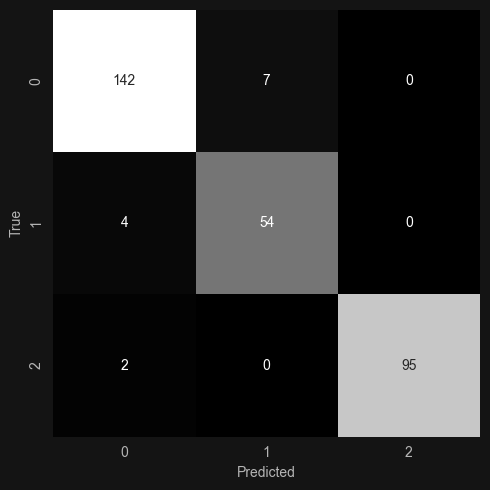

In [70]:
from sklearn.metrics import classification_report, confusion_matrix

report = classification_report(y_true, y_pred, target_names=labels)
print(report)

cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
fig = plt.figure(figsize=(5, 5))
fig = sb.heatmap(cm, annot=True, fmt='d', cbar=False, cmap='Greys_r')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()

# III Conclusion
We ended up with decent F1 score of 96%.
<br><br>
Significant impact noticed after applying:
- Adam optimizer
- weighting classes

Not huge impact noticed after enhancing images features.